<a href="https://colab.research.google.com/github/kawtarsouhail/job-fraud-detection-ML-DL-/blob/main/Job_recommnder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Business Problem
This project aims to detect fraudulent job postings and recommend relevant real jobs using NLP techniques.


# 2. Data Understanding

In [ ]:
from datasets import load_dataset

ds = load_dataset("victor/real-or-fake-fake-jobposting-prediction")
dataset = ds['train']
import pandas as pd
df = dataset.to_pandas()

df.head()

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

fake_job_postings.csv:   0%|          | 0.00/50.1M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/17880 [00:00<?, ? examples/s]

,job_id,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
0,1,Marketing Intern,"US, NY, New York",Marketing,None,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,None,0,1,0,Other,Internship,None,None,Marketing,0
1,2,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,None,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,0,1,0,Full-time,Not Applicable,None,Marketing and Advertising,Customer Service,0
2,3,Commissioning Machinery Assistant (CMA),"US, IA, Wever",None,None,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,None,0,1,0,None,None,None,None,None,0
3,4,Account Executive - Washington DC,"US, DC, Washington",Sales,None,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,0,1,0,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0
4,5,Bill Review Manager,"US, FL, Fort Worth",None,None,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0


# 3. Data Cleaning


In [ ]:
# remove duplicates
df = df.drop(columns=['job_id'])
df = df.drop_duplicates()
print(df.duplicated().sum())

0


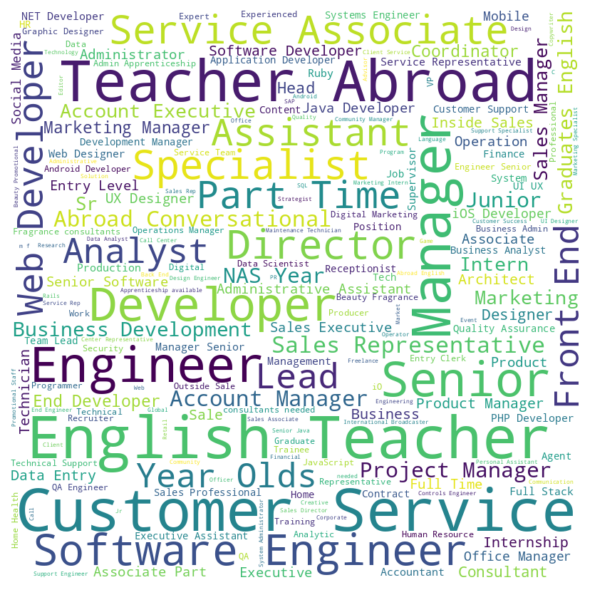

In [ ]:
# Visualize dataset using wordcloud

from wordcloud import WordCloud
from matplotlib import pyplot as plt

import seaborn as sns

# on the basis
job_titles_text = ' '.join(df['title'])
wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white').generate(job_titles_text)

# plotting Word cloud

plt.figure(figsize=(10, 6))
plt.imshow(wordcloud,interpolation='bilinear')
plt.axis("off")
plt.tight_layout()
plt.show()


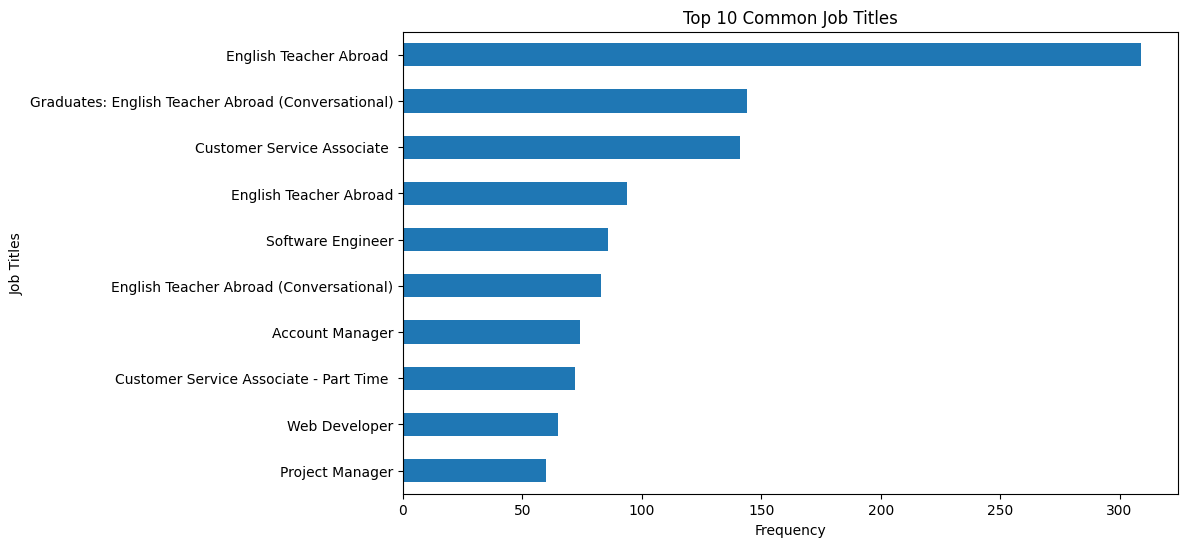

In [ ]:
job_titles_counts = df['title'].value_counts()

# plotting the top 10 job titles

top_job_tls = job_titles_counts.head(10)
plt.figure(figsize=(10, 6))
top_job_tls.sort_values().plot(kind='barh')
plt.title('Top 10 Common Job Titles')
plt.xlabel('Frequency')
plt.ylabel('Job Titles')
plt.show()

# 4. Feature Engineering


In [ ]:
# List of columns to concatenate
columns_to_concat = ['title','location','department','salary_range', 'company_profile','description','requirements','benefits','employment_type',
'required_experience','required_education','industry','function']

# Concatenate the values of specified columns into a new column 'job_posting'
df['job_posting'] = df[columns_to_concat].apply(lambda x: ' '.join(x.dropna().astype(str)), axis=1)

# Create a new DataFrame with columns 'job_posting' and 'fraudulent'
new_df = df[['job_posting', 'fraudulent']].copy()

In [ ]:
#pre_processing
import re
import nltk
from nltk.corpus import stopwords

nltk.download('stopwords')

def preprocess_text(text):
    # Remove newlines, carriage returns, and tabs
    text = re.sub('\n','', text)
    text = re.sub('\r','', text)
    text = re.sub('\t','', text)
    # Remove URLs
    text = re.sub(r"http\S+|www\S+|https\S+", "", text, flags=re.MULTILINE)

    # Remove special characters
    text = re.sub(r"[^a-zA-Z0-9\s]", "", text)

    # Remove punctuation
    text = re.sub(r'[^\w\s]', '', text)

    # Remove digits
    text = re.sub(r'\d', '', text)

    # Convert to lowercase
    text = text.lower()

    # Remove stop words
    stop_words = set(stopwords.words('english'))
    words = [word for word in text.split() if word.lower() not in stop_words]
    text = ' '.join(words)

    return text

new_df['job_posting'] = new_df['job_posting'].apply(preprocess_text)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
# 3. Lemmatization - It is a process to reduce a word to its root form, called a lemma.
import en_core_web_sm

nlp = en_core_web_sm.load()

def lemmatize_text(text):
    doc = nlp(text)
    return " ".join([token.lemma_ for token in doc])

new_df['job_posting'] = new_df['job_posting'].apply(lemmatize_text)


# Fraud job posting removal using LSTM


In [ ]:
from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import LSTM

import tensorflow as tf
tf.__version__

'2.19.0'

In [ ]:
X = new_df['job_posting']
y = new_df['fraudulent']

In [ ]:
# ONE hot coding
voc_size = 5000
onehot_repr = [one_hot(words, voc_size) for words in X]

sent_length = 40
X_seq = pad_sequences(onehot_repr, padding='pre', maxlen=sent_length)


# 5. Model Creating


In [ ]:

# Create the model
embedding_vector_features = 50
model = Sequential()
model.add(Embedding(voc_size, embedding_vector_features, input_length=sent_length))
model.add(Bidirectional(LSTM(100)))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))

model.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

print(model.summary())


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

None


# split the data to train data and test data

In [ ]:
import numpy as np
X_final = np.array(X_seq)
y_final = np.array(y)

from sklearn.model_selection import train_test_split

# Train-test split for LSTM
X_train_seq, X_test_seq, y_train_seq, y_test_seq = train_test_split(
    X_seq, y, test_size=0.25, random_state=42
)

In [ ]:
# training the model
model.fit(X_train_seq, y_train_seq, validation_data=(X_test_seq, y_test_seq), epochs=2, batch_size=64)


Epoch 1/2
207/207 ━━━━━━━━━━━━━━━━━━━━ 10s 15ms/step - accuracy: 0.9370 - loss: 0.2759 - val_accuracy: 0.9680 - val_loss: 0.1104
Epoch 2/2
207/207 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.9798 - loss: 0.0661 - val_accuracy: 0.9741 - val_loss: 0.1015


In [ ]:
# map the [0,1] to 0 or 1
y_pred_lstm = (model.predict(X_test_seq) > 0.5).astype("int32").flatten()

138/138 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


In [ ]:
# ========== LOGISTIC REGRESSION MODEL ==========

from sklearn.feature_extraction.text import TfidfVectorizer

# TF-IDF
tfidf = TfidfVectorizer(max_features=5000, ngram_range=(1,2), stop_words='english')
X_tfidf = tfidf.fit_transform(X)

# Train-test split for Logistic Regression
X_train_tfidf, X_test_tfidf, y_train_tfidf, y_test_tfidf = train_test_split(
    X_tfidf, y, test_size=0.25, random_state=42
)


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score

# Train model
lr_model = LogisticRegression(max_iter=1000)
lr_model.fit(X_train_tfidf, y_train_tfidf)

# Predictions
y_pred_lr = lr_model.predict(X_test_tfidf)

# 6. Model Evaluation




========== MODEL COMPARISON ==========
LSTM Accuracy: 0.9741
LSTM F1-score: 0.6851
Logistic Regression Accuracy: 0.9689
Logistic Regression F1-score: 0.5810

LSTM Confusion Matrix:


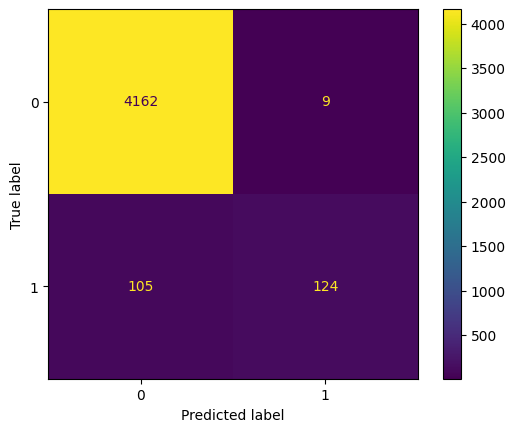


Logistic Regression Confusion Matrix:


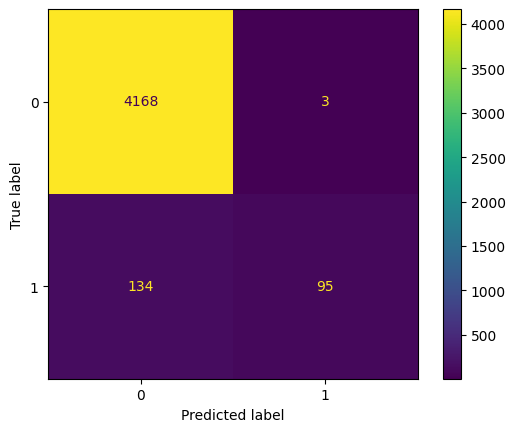


Logistic Regression Classification Report:

              precision    recall  f1-score   support

           0       0.97      1.00      0.98      4171
           1       0.97      0.41      0.58       229

    accuracy                           0.97      4400
   macro avg       0.97      0.71      0.78      4400
weighted avg       0.97      0.97      0.96      4400



In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt

print("========== MODEL COMPARISON ==========")

# LSTM metrics
lstm_acc = accuracy_score(y_test_seq, y_pred_lstm)
lstm_f1 = f1_score(y_test_seq, y_pred_lstm)

# Logistic Regression metrics
lr_acc = accuracy_score(y_test_tfidf, y_pred_lr)
lr_f1 = f1_score(y_test_tfidf, y_pred_lr)

print(f"LSTM Accuracy: {lstm_acc:.4f}")
print(f"LSTM F1-score: {lstm_f1:.4f}")
print(f"Logistic Regression Accuracy: {lr_acc:.4f}")
print(f"Logistic Regression F1-score: {lr_f1:.4f}")

# Confusion Matrix - LSTM
print("\nLSTM Confusion Matrix:")
ConfusionMatrixDisplay.from_predictions(y_test_seq, y_pred_lstm)
plt.show()

# Confusion Matrix - Logistic Regression
print("\nLogistic Regression Confusion Matrix:")
ConfusionMatrixDisplay.from_predictions(y_test_tfidf, y_pred_lr)
plt.show()

# Logistic Regression full report
print("\nLogistic Regression Classification Report:\n")
print(classification_report(y_test_tfidf, y_pred_lr))




# 7. Job Recommendation System




In [ ]:
# ========== JOB RECOMMENDATION SYSTEM ==========

from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

# Filter real jobs
real = df[df['fraudulent'] == 0].fillna('')
real['text'] = real['description'] + " " + real['requirements'] + " " + \
               real['required_experience'] + " " + real['required_education'] + " " + real['industry']

# Load model
sentence_model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')

# Create embeddings
emb_matrix = sentence_model.encode(real['text'].tolist())

In [ ]:
def smart_job_recommendation(user_input, top_n=5):
    """
    Universal Job Recommendation Function
    Works with:
    - Job titles
    - Keywords
    - Full profile descriptions
    """

    # 1. Create combined text (title + description)
    if 'combined_text' not in real.columns:
        real['combined_text'] = real['title'].fillna('') + " " + real['description'].fillna('')

    # 2. Encode combined job data only once
    global emb_matrix
    if 'emb_matrix' not in globals():
        emb_matrix = sentence_model.encode(
            real['combined_text'].tolist(),
            show_progress_bar=True
        )

    # 3. Encode user input
    user_embedding = sentence_model.encode([user_input])

    # 4. Compute cosine similarity
    similarities = cosine_similarity(user_embedding, emb_matrix)[0]

    # 5. Create result dataframe
    results_df = real.copy()
    results_df['similarity_score'] = similarities

    # 6. Sort and return top N results
    results_df = results_df.sort_values(by='similarity_score', ascending=False).head(top_n)

    return results_df[['title', 'location', 'industry', 'similarity_score']]



# Recommendation by user input
def recommend_by_profile(user_text, top_n=5):
    user_embedding = sentence_model.encode([user_text])
    similarities = cosine_similarity(user_embedding, emb_matrix)[0]
    real['similarity_score'] = similarities
    return real.sort_values(by='similarity_score', ascending=False).head(top_n)[
        ['title','location','industry','similarity_score']
    ]

In [ ]:
smart_job_recommendation("ML Developer", top_n=5)


,title,location,industry,similarity_score
4376,Python Developer at Growth Intelligence,"GB, LND, London",,0.486519
3640,Senior Data Scientist,"GR, I, Athens",Computer Software,0.475481
2320,Software Engineer,"GR, I, Vrilissia , Greece",Computer Software,0.473793
4443,Data analyst intern,"GB, LND, London",,0.473548
4524,Senior Developer at Growth Intelligence,"GB, LND, London",,0.468939


In [ ]:
recommend_by_profile("Backend developer with Python and Django",10)

,title,location,industry,similarity_score
8146,Python / Django Developer,"US, TX, Austin",Information Technology and Services,0.698575
7541,Python/Django Developer,"ES, AN, Malaga",Computer Software,0.614954
8068,Python Backend Engineers,"GB, LND, London",Financial Services,0.583270
3474,Software Engineer (Python),"GB, LND, London",Internet,0.581138
14560,Full Stack Python Developer,"DE, BE, Berlin",Computer Software,0.577837
12692,Contract Server Engineer (Python/Django),"US, TX, Austin",Computer Software,0.562736
8571,Back-End Python Developer,"NL, NH, Amsterdam",Information Technology and Services,0.561549
11354,Python Developer,"US, NY, New York",Computer Software,0.552153
4843,Back-end Developer Python/Django,"FI, ES, Helsinki",Computer Software,0.543035
11204,Senior Python Dev,"CA, ON, Toronto",Internet,0.541849


In [ ]:

import joblib

joblib.dump(tfidf, "/content/tfidf_vectorizer.pkl")
joblib.dump(lr_model, "/content/logistic_model.pkl")

# Si ton LSTM est bien entraîné :
model.save("/content/lstm_fraud_model.keras")


In [ ]:
!zip -r /content/models.zip \
/content/lstm_fraud_model.keras \
/content/tfidf_vectorizer.pkl \
/content/logistic_model.pkl


  adding: content/lstm_fraud_model.keras/ (stored 0%)
  adding: content/lstm_fraud_model.keras/2_Normalize/ (stored 0%)
  adding: content/lstm_fraud_model.keras/modules.json (deflated 62%)
  adding: content/lstm_fraud_model.keras/config_sentence_transformers.json (deflated 40%)
  adding: content/lstm_fraud_model.keras/sentence_bert_config.json (deflated 9%)
  adding: content/lstm_fraud_model.keras/special_tokens_map.json (deflated 80%)
  adding: content/lstm_fraud_model.keras/vocab.txt (deflated 53%)
  adding: content/lstm_fraud_model.keras/1_Pooling/ (stored 0%)
  adding: content/lstm_fraud_model.keras/1_Pooling/config.json (deflated 59%)
  adding: content/lstm_fraud_model.keras/config.json (deflated 47%)
  adding: content/lstm_fraud_model.keras/tokenizer.json (deflated 71%)
  adding: content/lstm_fraud_model.keras/model.safetensors (deflated 9%)
  adding: content/lstm_fraud_model.keras/tokenizer_config.json (deflated 73%)
  adding: content/lstm_fraud_model.keras/README.md (deflated 6

In [ ]:
from google.colab import files
files.download("/content/models.zip")